# Model Evaluation - kNN subset

Main model evaluation notebook showed that KNN using optuna to have a promissing performance. So I'll try to expand on that in the document. Additionally I will run random forest to select feature and run additional model using limited features.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

pd.set_option('precision', 4)
pd.options.display.max_seq_items = None
pd.options.display.max_columns = 50

In [14]:
X = pd.read_pickle('PKL/X_train.pkl')
y = pd.read_pickle('PKL/Y_train.pkl')

## Train/Test Split
I'm actually going to split my train data once more. It's because this is a competition dataset and I actually don't have the 'test' score result. So I will use the initial test features as a holdout set, and make another subset of train/test for validations.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13, test_size = 0.2)

In [16]:
# One Hot Encoding 
X_train_ohe = pd.get_dummies(X_train)
X_test_ohe = pd.get_dummies(X_test)

In [17]:
# Check if they have the same features
if X_train_ohe.shape[1] != X_test_ohe.shape[1]:
    print([x for x in X_train_ohe.columns if x not in X_test_ohe.columns])
    print([x for x in X_test_ohe.columns if x not in X_train_ohe.columns])
else: 
    print ('Good to go')

Good to go


In [18]:
# If they are not the same, add the column with 0s and fix the order
# X_test_ohe = X_test_ohe[X_train_ohe.columns]

In [19]:
from sklearn.metrics import f1_score, balanced_accuracy_score, plot_confusion_matrix, classification_report

## Dummy Classifier
I'll create a dummy classifier as a baseline score.

In [20]:
#keeping score
score_keeper = {}

In [21]:
from sklearn.dummy import DummyClassifier
dummyc = DummyClassifier(strategy = 'stratified') # using the default stratified strategy
dummyc.fit(X_train_ohe, y_train)
y_pred = dummyc.predict(X_test_ohe)

f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(balanced_accuracy_score(y_test, y_pred), 3)
print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['baseline'] = (f1_test, acc_test)


Test F1 score:  0.455 / Test Accuracy:  0.342


                         precision    recall  f1-score   support

             functional       0.55      0.55      0.55      4822
functional needs repair       0.08      0.08      0.08       678
         non functional       0.40      0.39      0.39      3410

               accuracy                           0.46      8910
              macro avg       0.34      0.34      0.34      8910
           weighted avg       0.45      0.46      0.45      8910



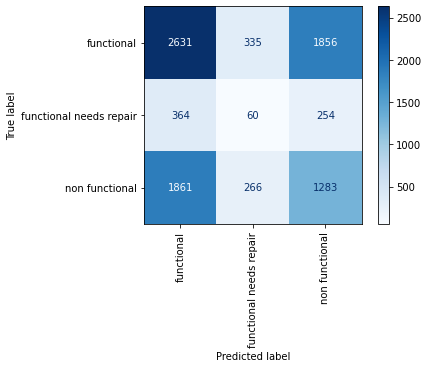

In [22]:
#plot_confusion_matrix(dummyc, X_test_ohe, y_test, xticks_rotation = 'vertical', cmap = plt.cm.Blues)
print(classification_report(y_test, y_pred))

## KNN
First, I will run K-Nearest Neighbors using GridSearchCV. 

### Standardization
For KNN, I will standardize all feature values.

In [23]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train_ohe)
X_test_scaled = scale.transform(X_test_ohe)

In [25]:
from sklearn.neighbors import KNeighborsClassifier
import optuna
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [26]:
def find_hyperp_KNN(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 31)
    algorithm = trial.suggest_categorical('algorithm', ['ball_tree', 'kd_tree'])
    leaf_size = trial.suggest_int('leaf_size', 2, 60)
    p = trial.suggest_categorical('p', [1, 2])
    knc = KNeighborsClassifier(weights = 'distance', 
                             n_neighbors = n_neighbors, 
                             algorithm = algorithm, 
                             leaf_size = leaf_size, 
                             p = p, n_jobs = 2)
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(knc, X_train_scaled, y_train, scoring = 'f1_weighted', cv = cv, n_jobs = 2))
    return (score)

knn_study = optuna.create_study(direction='maximize')
knn_study.optimize(find_hyperp_KNN, timeout = 4*60*60) # run for 4 hours

[I 2020-08-19 12:53:21,981] Trial 0 finished with value: 0.7344779827381714 and parameters: {'n_neighbors': 1, 'algorithm': 'ball_tree', 'leaf_size': 33, 'p': 1}. Best is trial 0 with value: 0.7344779827381714.
[I 2020-08-19 12:59:21,332] Trial 1 finished with value: 0.7354959503837666 and parameters: {'n_neighbors': 13, 'algorithm': 'ball_tree', 'leaf_size': 16, 'p': 2}. Best is trial 1 with value: 0.7354959503837666.
[I 2020-08-19 13:05:25,298] Trial 2 finished with value: 0.7488622778715428 and parameters: {'n_neighbors': 13, 'algorithm': 'kd_tree', 'leaf_size': 56, 'p': 1}. Best is trial 2 with value: 0.7488622778715428.
[I 2020-08-19 13:11:30,933] Trial 3 finished with value: 0.7377936401569644 and parameters: {'n_neighbors': 6, 'algorithm': 'ball_tree', 'leaf_size': 28, 'p': 2}. Best is trial 2 with value: 0.7488622778715428.
[I 2020-08-19 13:17:35,696] Trial 4 finished with value: 0.7454472410118377 and parameters: {'n_neighbors': 23, 'algorithm': 'kd_tree', 'leaf_size': 16, 'p'

[I 2020-08-19 16:41:31,742] Trial 38 finished with value: 0.7264455947174213 and parameters: {'n_neighbors': 1, 'algorithm': 'ball_tree', 'leaf_size': 37, 'p': 2}. Best is trial 19 with value: 0.7522755080506285.
[I 2020-08-19 16:50:20,853] Trial 39 finished with value: 0.7468486372347253 and parameters: {'n_neighbors': 20, 'algorithm': 'ball_tree', 'leaf_size': 42, 'p': 1}. Best is trial 19 with value: 0.7522755080506285.


In [27]:
# saving the study 
#mod = open('PKL/knn_study.pkl', 'wb')
#pickle.dump(knn_study, mod)
#mod.close()

In [28]:
knn_study.best_params

{'n_neighbors': 8, 'algorithm': 'kd_tree', 'leaf_size': 9, 'p': 1}

In [30]:
# Testing the best params on the test set
knc_opt = KNeighborsClassifier(algorithm = 'kd_tree', leaf_size = 9, n_neighbors=8, p =1, weights = 'distance')
knc_opt.fit(X_train_scaled, y_train)

y_pred = knc_opt.predict(X_test_scaled)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(balanced_accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['knn_opt'] = (f1_test, acc_test)

Test F1 score:  0.761 / Test Accuracy:  0.636


                         precision    recall  f1-score   support

             functional       0.79      0.84      0.81      4822
functional needs repair       0.45      0.32      0.37       678
         non functional       0.78      0.75      0.76      3410

               accuracy                           0.77      8910
              macro avg       0.67      0.64      0.65      8910
           weighted avg       0.76      0.77      0.76      8910



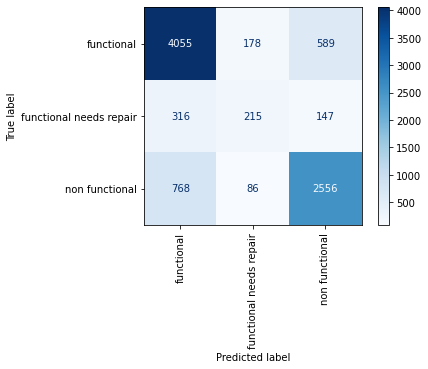

In [31]:
plot_confusion_matrix(knc_opt, X_test_scaled, y_test, xticks_rotation = 'vertical', cmap = plt.cm.Blues)
print(classification_report(y_test, y_pred))

Unfortunately even with the many hours of parameter tuning. This KNN did not improve too much, even though its recall rate for minority class improved a bit. KNN takes in all features and derive its prediction based on the location. So it does not do any feature selection itself, so maybe I should try removing some of the noisy feature data. I'll fit random forest to determine features with low feature importance. (Full random forest model is running on the main file.)

## Subsetting Features

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [ ]:
# select features from a simple random forest model
feat_select = SelectFromModel(RandomForestClassifier(n_estimators = 100))
feat_select.fit(X_train_ohe, y_train)

In [46]:
# subset to above average importance feature
X_train_limit = X_train_ohe[X_train_ohe.columns[feat_select.get_support()]]
X_test_limit = X_test_ohe[X_train_limit.columns]

In [47]:
# scale
X_train_limit_scaled = scale.fit_transform(X_train_limit)
X_test_limit_scaled = scale.transform(X_test_limit)

In [49]:
# Testing using the simple params on the other test 
knc_limit = KNeighborsClassifier(weights = 'distance')
knc_limit.fit(X_train_limit_scaled, y_train)

y_pred = knc_limit.predict(X_test_limit_scaled)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(balanced_accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['knn_limit'] = (f1_test, acc_test)

Test F1 score:  0.763 / Test Accuracy:  0.632


                         precision    recall  f1-score   support

             functional       0.79      0.84      0.82      4822
functional needs repair       0.41      0.30      0.34       678
         non functional       0.78      0.76      0.77      3410

               accuracy                           0.77      8910
              macro avg       0.66      0.63      0.64      8910
           weighted avg       0.76      0.77      0.76      8910



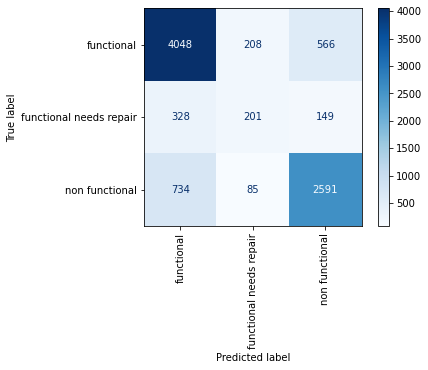

In [51]:
plot_confusion_matrix(knc_limit, X_test_limit_scaled, y_test, xticks_rotation = 'vertical', cmap = plt.cm.Blues)
print(classification_report(y_test, y_pred))

It didn't improve much, but did not drop. So at least for KNN these extra features are not overly complicating our model. I'll try to optimize it with optuna again using selected features. 

## Optimization on Subset

In [52]:
def find_hyperp_KNN_sel(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 31)
    algorithm = trial.suggest_categorical('algorithm', ['ball_tree', 'kd_tree'])
    leaf_size = trial.suggest_int('leaf_size', 2, 60)
    p = trial.suggest_categorical('p', [1, 2])
    knc = KNeighborsClassifier(weights = 'distance', 
                             n_neighbors = n_neighbors, 
                             algorithm = algorithm, 
                             leaf_size = leaf_size, 
                             p = p, n_jobs = 2)
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(knc, X_train_limit_scaled, y_train, scoring = 'f1_weighted', cv = cv, n_jobs = 2))
    return (score)

knn_study_2 = optuna.create_study(direction='maximize')
knn_study_2.optimize(find_hyperp_KNN_sel, timeout = 4*60*60) # run for 3 hours

[I 2020-08-19 18:35:35,212] Trial 0 finished with value: 0.7603107561150155 and parameters: {'n_neighbors': 24, 'algorithm': 'ball_tree', 'leaf_size': 21, 'p': 1}. Best is trial 0 with value: 0.7603107561150155.
[I 2020-08-19 18:36:42,608] Trial 1 finished with value: 0.7525935562232415 and parameters: {'n_neighbors': 29, 'algorithm': 'kd_tree', 'leaf_size': 27, 'p': 2}. Best is trial 0 with value: 0.7603107561150155.
[I 2020-08-19 18:38:12,414] Trial 2 finished with value: 0.7534040876021982 and parameters: {'n_neighbors': 17, 'algorithm': 'kd_tree', 'leaf_size': 6, 'p': 2}. Best is trial 0 with value: 0.7603107561150155.
[I 2020-08-19 18:39:03,951] Trial 3 finished with value: 0.7607738888551656 and parameters: {'n_neighbors': 8, 'algorithm': 'kd_tree', 'leaf_size': 43, 'p': 1}. Best is trial 3 with value: 0.7607738888551656.
[I 2020-08-19 18:40:06,055] Trial 4 finished with value: 0.7601457227970163 and parameters: {'n_neighbors': 22, 'algorithm': 'kd_tree', 'leaf_size': 39, 'p': 1}

[I 2020-08-19 20:20:35,544] Trial 38 finished with value: 0.7614006555439972 and parameters: {'n_neighbors': 9, 'algorithm': 'kd_tree', 'leaf_size': 43, 'p': 1}. Best is trial 38 with value: 0.7614006555439972.
[I 2020-08-19 20:21:31,189] Trial 39 finished with value: 0.7614006555439972 and parameters: {'n_neighbors': 9, 'algorithm': 'kd_tree', 'leaf_size': 43, 'p': 1}. Best is trial 38 with value: 0.7614006555439972.
[I 2020-08-19 20:22:20,911] Trial 40 finished with value: 0.7516620668373866 and parameters: {'n_neighbors': 7, 'algorithm': 'kd_tree', 'leaf_size': 41, 'p': 2}. Best is trial 38 with value: 0.7614006555439972.
[I 2020-08-19 20:23:13,757] Trial 41 finished with value: 0.7614006555439972 and parameters: {'n_neighbors': 9, 'algorithm': 'kd_tree', 'leaf_size': 36, 'p': 1}. Best is trial 38 with value: 0.7614006555439972.
[I 2020-08-19 20:24:05,258] Trial 42 finished with value: 0.7614006555439972 and parameters: {'n_neighbors': 9, 'algorithm': 'kd_tree', 'leaf_size': 36, 'p'

[I 2020-08-19 21:38:39,353] Trial 76 finished with value: 0.7595709002354207 and parameters: {'n_neighbors': 14, 'algorithm': 'kd_tree', 'leaf_size': 37, 'p': 1}. Best is trial 38 with value: 0.7614006555439972.
[I 2020-08-19 21:39:36,298] Trial 77 finished with value: 0.7614006555439972 and parameters: {'n_neighbors': 9, 'algorithm': 'kd_tree', 'leaf_size': 49, 'p': 1}. Best is trial 38 with value: 0.7614006555439972.
[I 2020-08-19 21:40:31,677] Trial 78 finished with value: 0.7590262108320148 and parameters: {'n_neighbors': 7, 'algorithm': 'kd_tree', 'leaf_size': 38, 'p': 1}. Best is trial 38 with value: 0.7614006555439972.
[I 2020-08-19 21:41:29,561] Trial 79 finished with value: 0.7598841340685412 and parameters: {'n_neighbors': 12, 'algorithm': 'kd_tree', 'leaf_size': 49, 'p': 1}. Best is trial 38 with value: 0.7614006555439972.
[I 2020-08-19 21:42:22,836] Trial 80 finished with value: 0.7607738888551656 and parameters: {'n_neighbors': 8, 'algorithm': 'kd_tree', 'leaf_size': 30, '

[I 2020-08-19 22:17:19,810] Trial 114 finished with value: 0.7598841340685412 and parameters: {'n_neighbors': 12, 'algorithm': 'kd_tree', 'leaf_size': 44, 'p': 1}. Best is trial 38 with value: 0.7614006555439972.
[I 2020-08-19 22:18:11,729] Trial 115 finished with value: 0.7607738888551656 and parameters: {'n_neighbors': 8, 'algorithm': 'kd_tree', 'leaf_size': 41, 'p': 1}. Best is trial 38 with value: 0.7614006555439972.
[I 2020-08-19 22:19:16,283] Trial 116 finished with value: 0.7614006555439972 and parameters: {'n_neighbors': 9, 'algorithm': 'kd_tree', 'leaf_size': 39, 'p': 1}. Best is trial 38 with value: 0.7614006555439972.
[I 2020-08-19 22:20:13,370] Trial 117 finished with value: 0.7605806357214928 and parameters: {'n_neighbors': 10, 'algorithm': 'kd_tree', 'leaf_size': 36, 'p': 1}. Best is trial 38 with value: 0.7614006555439972.
[I 2020-08-19 22:21:10,125] Trial 118 finished with value: 0.7614006555439972 and parameters: {'n_neighbors': 9, 'algorithm': 'kd_tree', 'leaf_size': 

In [53]:
# saving the study 
mod = open('PKL/knn_study_2.pkl', 'wb')
pickle.dump(knn_study_2, mod)
mod.close()

In [54]:
knn_study_2.best_params

{'n_neighbors': 9, 'algorithm': 'kd_tree', 'leaf_size': 43, 'p': 1}

In [55]:
# Testing the best params on the test set
knn_opt_limit = KNeighborsClassifier(algorithm = 'kd_tree', leaf_size = 43, n_neighbors=9, p =1, weights = 'distance')
knn_opt_limit.fit(X_train_limit_scaled, y_train)

y_pred = knn_opt_limit.predict(X_test_limit_scaled)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(balanced_accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['knn_opt_limit'] = (f1_test, acc_test)

Test F1 score:  0.765 / Test Accuracy:  0.632


                         precision    recall  f1-score   support

             functional       0.79      0.85      0.82      4822
functional needs repair       0.44      0.29      0.35       678
         non functional       0.79      0.75      0.77      3410

               accuracy                           0.77      8910
              macro avg       0.67      0.63      0.65      8910
           weighted avg       0.76      0.77      0.76      8910



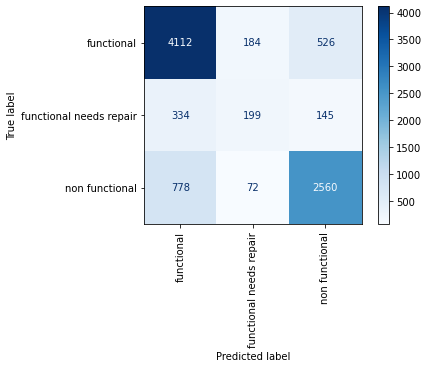

In [56]:
plot_confusion_matrix(knn_opt_limit, X_test_limit_scaled, y_test, 
                      xticks_rotation = 'vertical', cmap = plt.cm.Blues)
print(classification_report(y_test, y_pred))

In [71]:
# Simple parameter did the best, let's try to increase the n_neighbors to fix some overfit issue.
knc_limit_addK = KNeighborsClassifier(n_neighbors = 7, weights = 'distance')
knc_limit_addK.fit(X_train_limit_scaled, y_train)

y_pred = knc_limit_addK.predict(X_test_limit_scaled)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(balanced_accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['knn_limit_K7'] = (f1_test, acc_test)

Test F1 score:  0.761 / Test Accuracy:  0.627


In [73]:
X_test_limit.columns

Index(['amount_tsh', 'date_recorded', 'gps_height', 'longitude', 'latitude',
       'population', 'public_meeting', 'permit', 'construction_year',
       'basin_lat', 'basin_long', 'dist_to_basin', 'lga_lat', 'lga_long',
       'dist_to_lga', 'funder_government of tanzania', 'funder_others',
       'installer_dwe', 'installer_government', 'installer_others',
       'subvillage_others', 'region_iringa', 'district_code_1',
       'district_code_2', 'district_code_3', 'district_code_4',
       'scheme_management_vwc', 'scheme_management_wug', 'management_vwc',
       'management_wug', 'payment_type_annually', 'payment_type_monthly',
       'payment_type_never pay', 'payment_type_on failure',
       'payment_type_per bucket', 'payment_type_unknown',
       'water_quality_salty', 'water_quality_soft', 'water_quality_unknown',
       'quantity_dry', 'quantity_enough', 'quantity_insufficient',
       'quantity_seasonal', 'source_machine dbh',
       'source_rainwater harvesting', 'source_rive